# Multi-label Text Classification with BERT and PyTorch Lightning

> TL;DR Learn how to prepare a dataset with toxic comments for multi-label text classification (tagging). We'll fine-tune BERT using PyTorch Lightning and evaluate the model.

Multi-label text classification (or tagging text) is one of the most common tasks you'll encounter when doing NLP. Modern Transformer-based models (like BERT) make use of pre-training on vast amounts of text data that makes fine-tuning faster, use fewer resources and more accurate on small(er) datasets.

In this tutorial, you'll learn how to:

- Load, balance and split text data into sets
- Tokenize text (with BERT tokenizer) and create PyTorch dataset
- Fine-tune BERT model with PyTorch Lightning
- Find out about warmup steps and use a learning rate scheduler
- Use area under the ROC and binary cross-entropy to evaluate the model during training
- How to make predictions using the fine-tuned BERT model
- Evaluate the performance of the model for each class (possible comment tag)

Will our model be any good for toxic text detection?

- [Read the tutorial](https://curiousily.com/posts/multi-label-text-classification-with-bert-and-pytorch-lightning/)
- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/14Ea4lIzsn5EFvPpYKtWStXEByT9qmbkj?usp=sharing)
- [Read the *Getting Things Done with Pytorch* book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

In [ ]:
!nvidia-smi

Thu Dec 30 05:54:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install pytorch-lightning==1.2.8 --quiet
!pip install transformers==4.10.2 --quiet

In [ ]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
import transformers
print(transformers.__version__)
print(transformers.__spec__)

import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

pl.seed_everything(RANDOM_SEED)

4.10.2
ModuleSpec(name='transformers', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7f59796737d0>, origin='/usr/local/lib/python3.7/dist-packages/transformers/__init__.py', submodule_search_locations=['/usr/local/lib/python3.7/dist-packages/transformers'])


Global seed set to 42


42

## Data

Our dataset contains potentially offensive (toxic) comments and comes from the [Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge). Let's start by download the data (from Google Drive):

In [ ]:
# !gdown --id 1VuQ-U7TtggShMeuRSA_hzC8qGDl2LRkr

Let's load and look at the data:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#pic
df = pd.read_csv("/content/drive/Shareddrives/葉向原老師的Lab/Mos Burger/Data/multi_label_data.csv", index_col=[0])
df.head()

,comment,label,Service,Environment,Food
0,日出燒肉蛋堡中間是一顆炸過的水煮蛋味道還不錯,Food,0,0,1
1,服務很親切，環境很舒適，餐點很美味，每個人都很殷勤工作，剛剛是“特殊兒”送餐來，很友善認真，...,Service#Enviroment#Food,1,1,1
2,店員服務態度佳，常常光顧，不知道為何會有人說店員態度不好，反而是很多客人態度差要求多,Service,1,0,0
3,“換”敢不敢寫大一點把雞塊還我= =,Food,0,0,1
4,2018-01 平日早上，點塔塔鱈魚堡，感覺size縮水了！服務友善，店內寬敞明亮，有很大的...,Food#Enviroment,0,1,1


We have text (comment) and six different toxic labels. Note that we have clean content, too. 

Let's split the data:

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.05)
train_df.shape, val_df.shape

((3409, 5), (180, 5))

## Preprocessing

Let's look at the distribution of the labels:

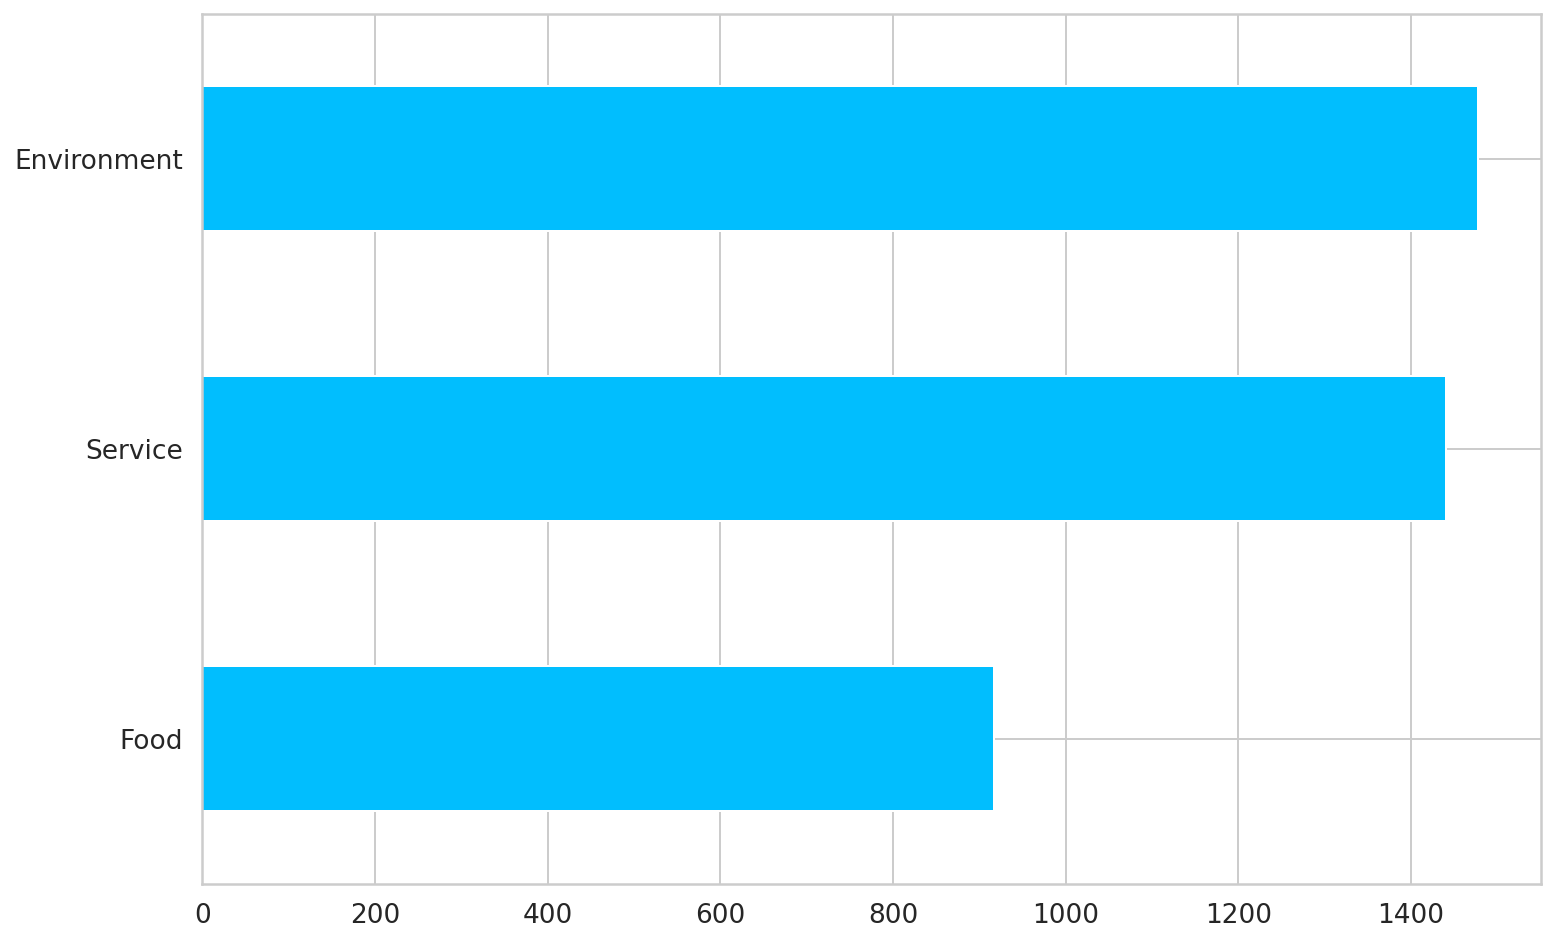

In [ ]:
#pic 比數
LABEL_COLUMNS = df.columns.tolist()[2:]
df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

We have a severe case of imbalance. But that is not the full picture. What about the toxic vs clean comments?

Again, we have a severe imbalance in favor of the clean comments. To combat this, we'll sample 15,000 examples from the clean comments and create a new training set:

### Tokenization

We need to convert the raw text into a list of tokens. For that, we'll use the built-in BertTokenizer:

In [ ]:
BERT_MODEL_NAME = 'bert-base-chinese'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

Let's try it out on a sample comment:

In [ ]:
sample_row = df.iloc[16]
sample_comment = sample_row.comment
sample_labels = sample_row[LABEL_COLUMNS]

print(sample_comment)
print()
print(sample_labels.to_dict())

店員服務不佳

{'Service': 1, 'Environment': 0, 'Food': 0}


In [ ]:
#pic 最大長度有限制
encoding = tokenizer.encode_plus(
  sample_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
encoding["input_ids"].shape, encoding["attention_mask"].shape

(torch.Size([1, 512]), torch.Size([1, 512]))

The result of the encoding is a dictionary with token ids `input_ids` and an attention mask `attention_mask` (which tokens should be used by the model 1 - use or 0 - don't use).

Let's look at their contents:

In [ ]:
encoding["input_ids"].squeeze()[:20]

tensor([ 101, 2421, 1519, 3302, 1243,  679,  881,  102,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [ ]:
encoding["attention_mask"].squeeze()[:20]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

You can also inverse the tokenization and get back (kinda) the words from the token ids:

In [ ]:
#pic ['cls']開頭、結束、補齊
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze())[:20])

['[CLS]', '店', '員', '服', '務', '不', '佳', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


We need to specify the maximum number of tokens when encoding (512 is the maximum we can do). Let's check the number of tokens per comment:

In [ ]:
token_counts = []

for _, row in train_df.iterrows():
  token_count = len(tokenizer.encode(
    row["comment"], 
    max_length=512, 
    truncation=True
  ))
  token_counts.append(token_count)

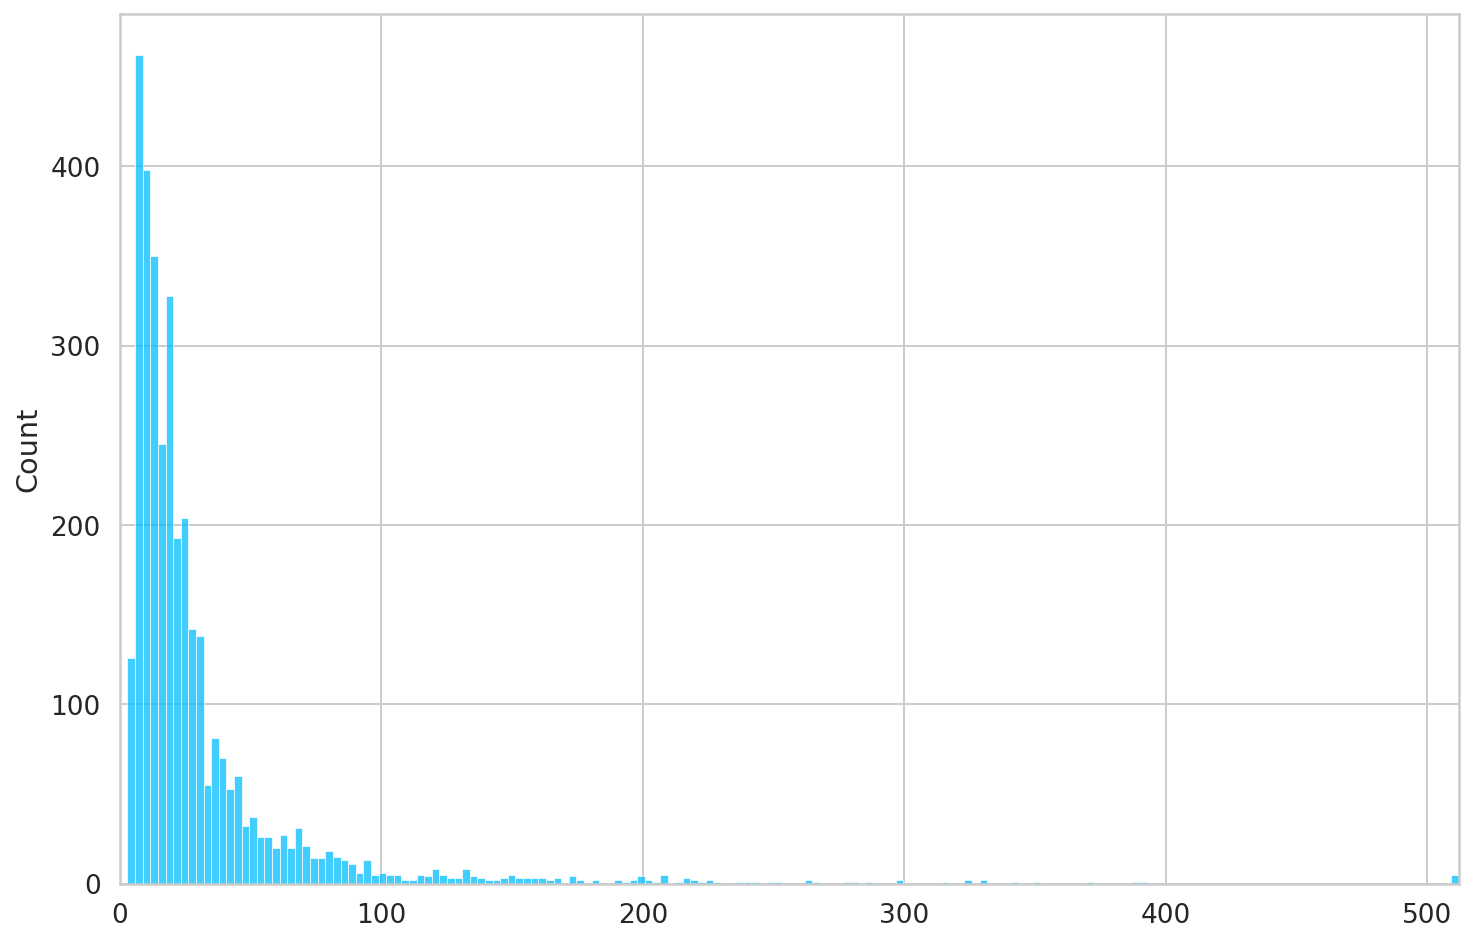

In [ ]:
#pic 句子長度
sns.histplot(token_counts)
plt.xlim([0, 512]);

Most of the comments contain less than 300 tokens or more than 512. So, we'll stick with the limit of 512.

In [ ]:
MAX_TOKEN_COUNT = 512

### Dataset

We'll wrap the tokenization process in a PyTorch Dataset, along with converting the labels to tensors:

In [ ]:
class ToxicCommentsDataset(Dataset):

  def __init__(
    self, 
    data: pd.DataFrame, 
    tokenizer: BertTokenizer, 
    max_token_len: int = 128
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len
    
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]

    comment_text = data_row.comment
    labels = data_row[LABEL_COLUMNS]

    encoding = self.tokenizer.encode_plus(
      comment_text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return dict(
      comment_text=comment_text,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=torch.FloatTensor(labels)
    )

Let's have a look at a sample item from the dataset:

In [ ]:
train_dataset = ToxicCommentsDataset(
  train_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

sample_item = train_dataset[0]
sample_item.keys()

dict_keys(['comment_text', 'input_ids', 'attention_mask', 'labels'])

In [ ]:
sample_item["comment_text"]

'重新裝潢後環境變得乾淨明亮 ，可活動的椅子方便不少 ，有用心 ！'

In [ ]:
sample_item["labels"]

tensor([0., 1., 0.])

In [ ]:
sample_item["input_ids"].shape

torch.Size([512])

Let's load the BERT model and pass a sample of batch data through:

In [ ]:
#pic pretrained model
bert_model = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
sample_batch = next(iter(DataLoader(train_dataset, batch_size=8, num_workers=2)))
sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape

(torch.Size([8, 512]), torch.Size([8, 512]))

In [ ]:
output = bert_model(sample_batch["input_ids"], sample_batch["attention_mask"])

In [ ]:
output.last_hidden_state.shape, output.pooler_output.shape

(torch.Size([8, 512, 768]), torch.Size([8, 768]))

The `768` dimension comes from the BERT hidden size:

In [ ]:
bert_model.config.hidden_size

768

The larger version of BERT has more attention heads and a larger hidden size.

We'll wrap our custom dataset into a [LightningDataModule](https://pytorch-lightning.readthedocs.io/en/stable/extensions/datamodules.html):

In [ ]:
class ToxicCommentDataModule(pl.LightningDataModule):

  def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  def setup(self, stage=None):
    self.train_dataset = ToxicCommentsDataset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )

    self.test_dataset = ToxicCommentsDataset(
      self.test_df,
      self.tokenizer,
      self.max_token_len
    )

  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=2
    )

  def val_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

`ToxicCommentDataModule` encapsulates all data loading logic and returns the necessary data loaders. Let's create an instance of our data module:

In [ ]:
#pic model
N_EPOCHS = 10
BATCH_SIZE = 12
MAX_TOKEN_COUNT = 512

data_module = ToxicCommentDataModule(
  train_df,
  val_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)

## Model

Our model will use a pre-trained [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and a linear layer to convert the BERT representation to a classification task. We'll pack everything in a [LightningModule](https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html):


In [ ]:
class ToxicCommentTagger(pl.LightningModule):

  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss()

  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)    
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  def training_epoch_end(self, outputs):
    
    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)

    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)

    for i, name in enumerate(LABEL_COLUMNS):
      class_roc_auc = auroc(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)


  def configure_optimizers(self):

    optimizer = AdamW(self.parameters(), lr=2e-5)

    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )

    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

Most of the implementation is just a boilerplate. Two points of interest are the way we configure the optimizers and calculating the area under ROC. We'll dive a bit deeper into those next.

### Optimizer scheduler

The job of a scheduler is to change the learning rate of the optimizer during training. This might lead to better performance of our model. We'll use the [get_linear_schedule_with_warmup](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#transformers.get_linear_schedule_with_warmup).

Let's have a look at a simple example to make things clearer:

In [ ]:
dummy_model = nn.Linear(2, 1)

optimizer = AdamW(params=dummy_model.parameters(), lr=0.001)

warmup_steps = 20
total_training_steps = 100

scheduler = get_linear_schedule_with_warmup(
  optimizer, 
  num_warmup_steps=warmup_steps,
  num_training_steps=total_training_steps
)

learning_rate_history = []

for step in range(total_training_steps):
  optimizer.step()
  scheduler.step()
  learning_rate_history.append(optimizer.param_groups[0]['lr'])

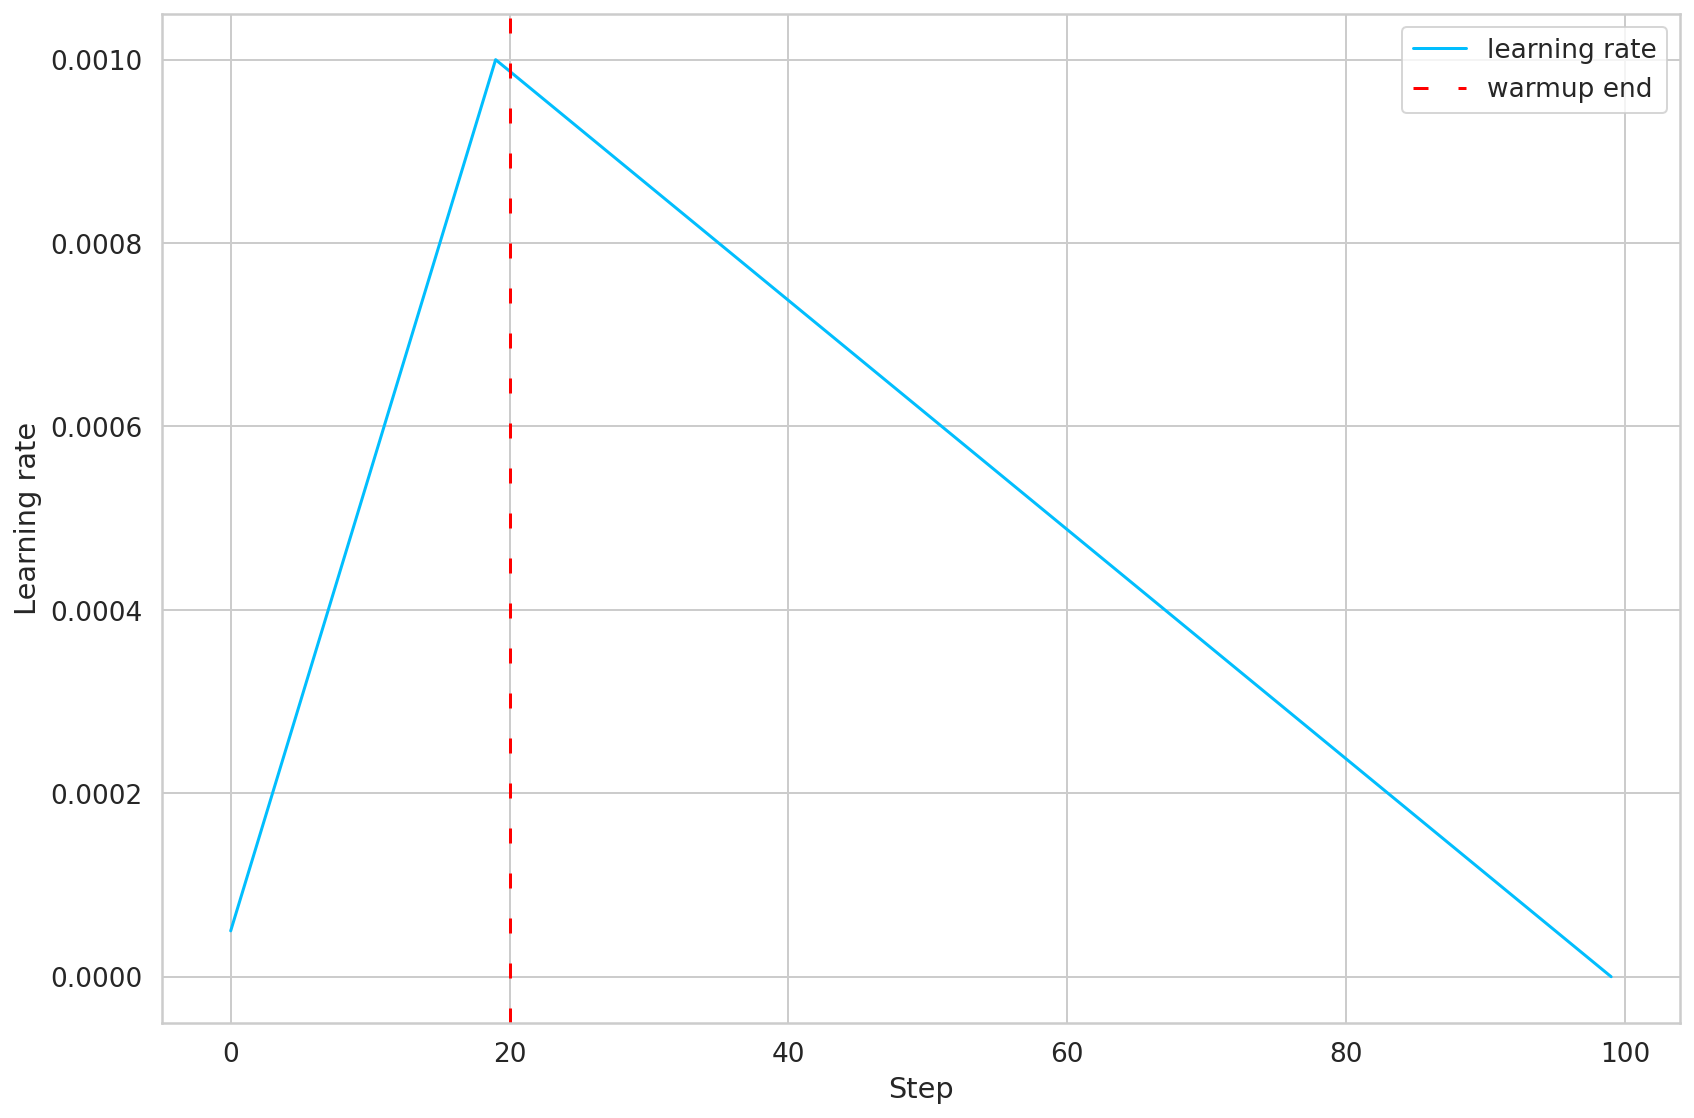

In [ ]:
plt.plot(learning_rate_history, label="learning rate")
plt.axvline(x=warmup_steps, color="red", linestyle=(0, (5, 10)), label="warmup end")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Learning rate")
plt.tight_layout();

We simulate 100 training steps and tell the scheduler to warm up for the first 20. The learning rate grows to the initial fixed value of 0.001 during the warm-up and then goes down (linearly) to 0.

To use the scheduler, we need to calculate the number of training and warm-up steps. The number of training steps per epoch is equal to `number of training examples / batch size`. The number of total training steps is `training steps per epoch * number of epochs`:

In [ ]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

We'll use a fifth of the training steps for a warm-up:

In [ ]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(568, 2840)

We can now create an instance of our model:

In [ ]:
model = ToxicCommentTagger(
  n_classes=len(LABEL_COLUMNS),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps 
)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Evaluation

Multi-label classification boils down to doing binary classification for each label/tag.

We'll use Binary Cross Entropy to measure the error for each label. PyTorch has [BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html), which we're going to combine with a sigmoid function (as we did in the model implementation). Let's look at an example:

In [ ]:
criterion = nn.BCELoss()

prediction = torch.FloatTensor(
  [10.95873564, 1.07321467, 1.58524066, 0.03839076, 15.72987556, 1.09513213]
)
labels = torch.FloatTensor(
  [1., 0., 0., 0., 1., 0.]
) 

In [ ]:
torch.sigmoid(prediction)

tensor([1.0000, 0.7452, 0.8299, 0.5096, 1.0000, 0.7493])

In [ ]:
criterion(torch.sigmoid(prediction), labels)

tensor(0.8725)

We can use the same approach to calculate the loss of the predictions:

In [ ]:
_, predictions = model(sample_batch["input_ids"], sample_batch["attention_mask"])
predictions

tensor([[0.4631, 0.4875, 0.5500],
        [0.4515, 0.4937, 0.5750],
        [0.3887, 0.4346, 0.4966],
        [0.4323, 0.4319, 0.5431],
        [0.4628, 0.3881, 0.6265],
        [0.4852, 0.4546, 0.5493],
        [0.4317, 0.4441, 0.5377],
        [0.4816, 0.3746, 0.4628]], grad_fn=<SigmoidBackward0>)

In [ ]:
criterion(predictions, sample_batch["labels"])

tensor(0.7283, grad_fn=<BinaryCrossEntropyBackward0>)

#### ROC Curve

Another metric we're going to use is the area under the Receiver operating characteristic (ROC) for each tag. ROC is created by plotting the True Positive Rate (TPR) vs False Positive Rate (FPR):

$$
\text{TPR} = \frac{\text{TP}}{\text{TP} \text{+} \text{FN}}
$$

$$
\text{FPR} = \frac{\text{FP}}{\text{FP} \text{+} \text{TN}}
$$




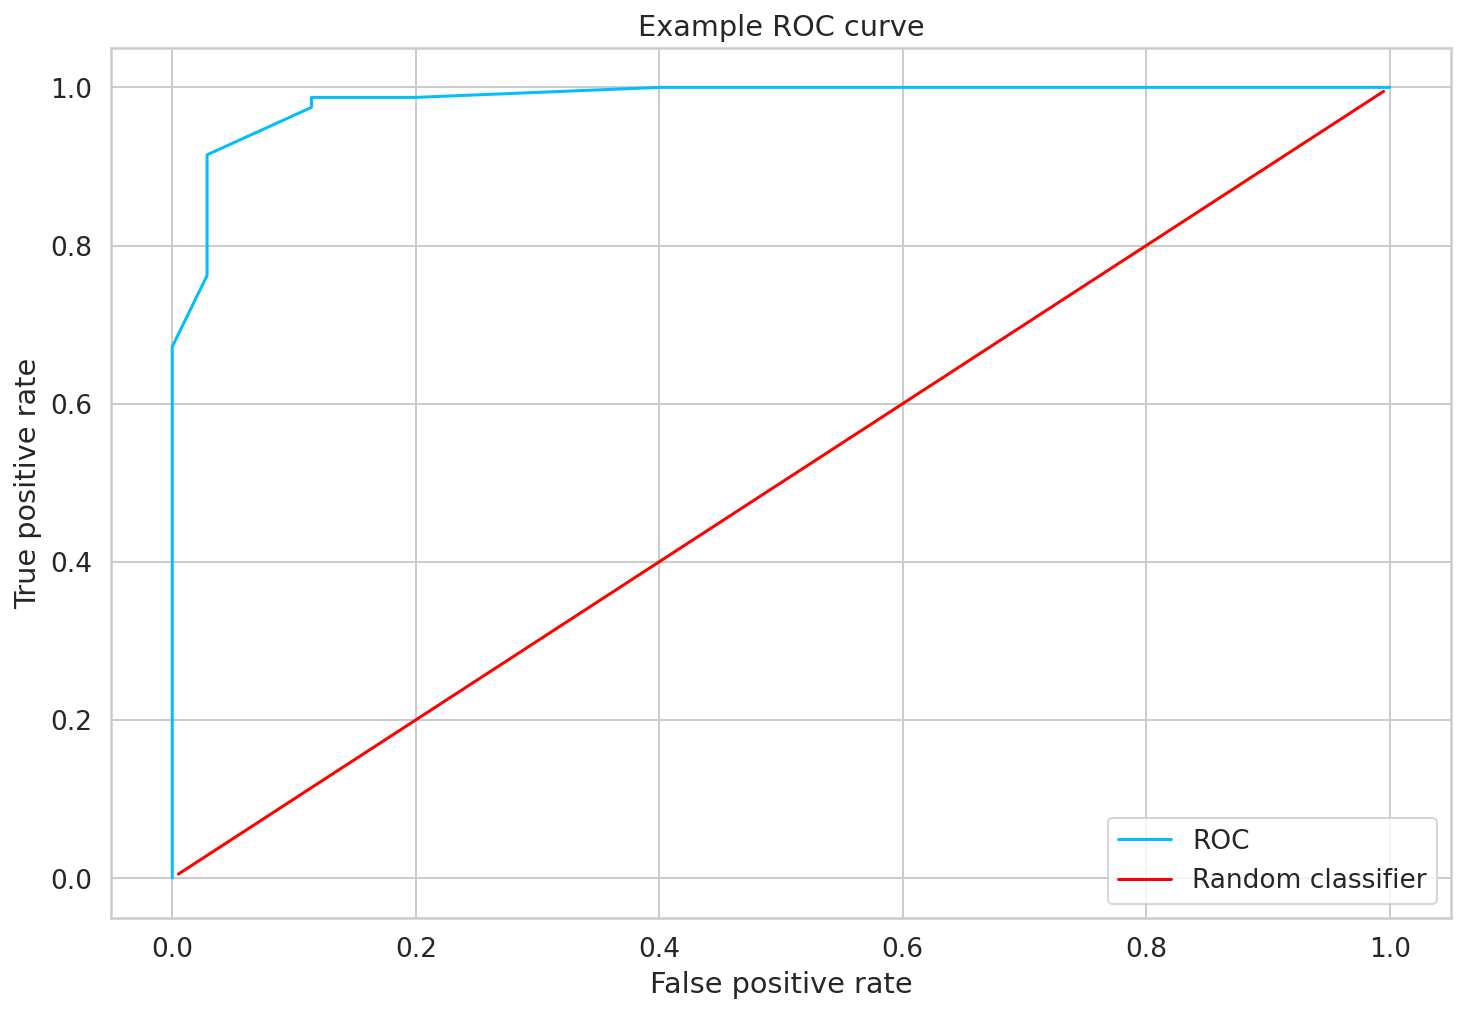

In [ ]:
from sklearn import metrics

fpr = [0.        , 0.        , 0.        , 0.02857143, 0.02857143,
       0.11428571, 0.11428571, 0.2       , 0.4       , 1.        ]

tpr = [0.        , 0.01265823, 0.67202532, 0.76202532, 0.91468354,
       0.97468354, 0.98734177, 0.98734177, 1.        , 1.        ]

_, ax = plt.subplots()
ax.plot(fpr, tpr, label="ROC")
ax.plot([0.05, 0.95], [0.05, 0.95], transform=ax.transAxes, label="Random classifier", color="red")
ax.legend(loc=4)
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title("Example ROC curve")
plt.show();

## Training

In [ ]:
!rm -rf lightning_logs/
!rm -rf checkpoints/

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs

The beauty of PyTorch Lightning is that you can build a standard pipeline that you like and train (almost?) every model you might imagine. I prefer to use at least 3 components.

Checkpointing that saves the best model (based on validation loss):

In [ ]:
checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)

Log the progress in TensorBoard:

In [ ]:
logger = TensorBoardLogger("lightning_logs", name="toxic-comments")

And early stopping triggers when the loss hasn't improved for the last 2 epochs (you might want to remove/reconsider this when training on real-world projects):

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

We can start the training process:

In [ ]:
trainer = pl.Trainer(
  logger=logger,
  checkpoint_callback=checkpoint_callback,
  callbacks=[early_stopping_callback],
  max_epochs=N_EPOCHS,
  gpus=1,
  progress_bar_refresh_rate=30
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [ ]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 102 M 
1 | classifier | Linear    | 2.3 K 
2 | criterion  | BCELoss   | 0     
-----------------------------------------
102 M     Trainable params
0         Non-trainable params
102 M     Total params
409.080   Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: `pos_label` automatically set 1.
  warnings.warn(*args, **kwargs)


Validating: 0it [00:00, ?it/s]

Epoch 0, global step 284: val_loss reached 0.25530 (best 0.25530), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 569: val_loss reached 0.17953 (best 0.17953), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, step 854: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 1139: val_loss reached 0.15410 (best 0.15410), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, step 1424: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, step 1709: val_loss was not in top 1


1

The model improved for (only) 2 epochs. We'll have to evaluate it to see whether it is any good. Let's double-check the validation loss:

In [ ]:
trainer.test()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.15409623086452484}
--------------------------------------------------------------------------------


[{'test_loss': 0.15409623086452484}]

## Predictions

I like to look at a small sample of predictions after the training is complete. This builds intuition about the quality of the predictions (qualitative evaluation).

Let's load the best version (according to the validation loss) of our model:

In [ ]:
trained_model = ToxicCommentTagger.load_from_checkpoint(
  trainer.checkpoint_callback.best_model_path,
  n_classes=len(LABEL_COLUMNS)
)
trained_model.eval()
trained_model.freeze()

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


We put our model into "eval" mode, and we're ready to make some predictions. Here's the prediction on a sample (totally fictional) comment:

In [ ]:
# test_comment = "很吵鬧又很難吃"

# encoding = tokenizer.encode_plus(
#   test_comment,
#   add_special_tokens=True,
#   max_length=512,
#   return_token_type_ids=False,
#   padding="max_length",
#   return_attention_mask=True,
#   return_tensors='pt',
# )

# _, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
# test_prediction = test_prediction.flatten().numpy()

# for label, prediction in zip(LABEL_COLUMNS, test_prediction):
#   print(f"{label}: {prediction}")

Looks good. This one is pretty clean. We'll reduce the noise of the predictions by thresholding (0.5) them. We'll take only tag predictions above (or equal) to the threshold. Let's try something toxic:

In [ ]:
#demo
#大於0.5就是1
THRESHOLD = 0.5

test_comment = "很吵又很難吃，餐點很慢"
encoding = tokenizer.encode_plus(
  test_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()

label_list = []
for label, prediction in zip(LABEL_COLUMNS, test_prediction):
  print(f"{label}: {prediction}")
  if prediction < THRESHOLD:
    label_list.append(0)
  else:
    label_list.append(1)

print(label_list)

Service: 0.9693803191184998
Environment: 0.8816474080085754
Food: 0.9921459555625916
[1, 1, 1]


I definitely agree with those tags. It looks like our model is doing something reasonable, on those two examples.

## Evaluation

Let's get a more complete overview of the performance of our model. We'll start by taking all predictions and labels from the validation set:

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

val_dataset = ToxicCommentsDataset(
  val_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

predictions = []
labels = []

for item in tqdm(val_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device), 
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

  0%|          | 0/180 [00:00<?, ?it/s]

One simple metric is the accuracy of the model:

In [ ]:
accuracy(predictions, labels, threshold=THRESHOLD)

tensor(0.9426)

That's great, but you should take this result with a grain of salt. We have a very imbalanced dataset. Let's check the ROC for each tag:

In [ ]:
print("AUROC per tag")
for i, name in enumerate(LABEL_COLUMNS):
  tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
  print(f"{name}: {tag_auroc}")

AUROC per tag
Service: 0.9680267572402954
Environment: 0.9827934503555298
Food: 0.9863374829292297


Very good results, but just before we go party, let's check the classification report for each class. To make this work, we must apply thresholding to the predictions:

In [ ]:
#pic
y_pred = predictions.numpy()
y_true = labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > THRESHOLD, upper, lower)

print(classification_report(
  y_true, 
  y_pred, 
  target_names=LABEL_COLUMNS, 
  zero_division=0
))

              precision    recall  f1-score   support

     Service       0.89      0.91      0.90        65
 Environment       0.88      0.97      0.93        76
        Food       0.95      0.91      0.93        45

   micro avg       0.90      0.94      0.92       186
   macro avg       0.91      0.93      0.92       186
weighted avg       0.90      0.94      0.92       186
 samples avg       0.76      0.77      0.75       186



That gives us a much more realistic picture of the overall performance. The model makes mistakes on the tags will low amounts of examples. What can you do about it?

## Summary

Great job, you have a model that can tell (to some extent) if a text is toxic (and what kind) or not! Fine-tuning modern pre-trained Transformer models allow you to get high accuracy on a variety of NLP tasks with little compute power and small datasets.

- [Read the tutorial](https://curiousily.com/posts/multi-label-text-classification-with-bert-and-pytorch-lightning/)
- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/14Ea4lIzsn5EFvPpYKtWStXEByT9qmbkj?usp=sharing)
- [Read the *Getting Things Done with Pytorch* book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

In this tutorial, you'll learned how to:

- Load, balance and split text data into sets
- Tokenize text (with BERT tokenizer) and create PyTorch dataset
- Fine-tune BERT model with PyTorch Lightning
- Find out about warmup steps and use a learning rate scheduler
- Use area under the ROC and binary cross-entropy to evaluate the model during training
- How to make predictions using the fine-tuned BERT model
- Evaluate the performance of the model for each class (possible comment tag)

Can you increase the accuracy of the model? How about better parameters or different learning rate scheduling? Let me know in the comments.



## References

- [Toxic comments EDA](https://www.kaggle.com/swathi314/toxic-comment-classification-eda)
- [Receiver operating characteristic on ML crash course](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)